# Train CVAE Model for Conditional Generation

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.cvae import *
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

charset = '?P25$]FO-S.Hc=71(ln63NC4[+)^@'
charlen = len(charset)
print('the charset(inculde begin end and pad char) achieved from dataset :', charset)
print('the total num of charset is :', charlen)
# create the char to index and index to char dictionary
char_to_index = dict((c, i) for i, c in enumerate(charset))
index_to_char = dict((i, c) for i, c in enumerate(charset))
char_list = [k for k, v in char_to_index.items()]

the charset(inculde begin end and pad char) achieved from dataset : ?P25$]FO-S.Hc=71(ln63NC4[+)^@
the total num of charset is : 29


In [5]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 10
seqlen = 127

In [6]:
src_smiles, tgt_smiles = smiles_padding(train_smiles)
tgt_seq = smiles_to_sequence(tgt_smiles, char_to_index)
tgt_seq = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq]).long()
src_smiles_test, tgt_smiles_test = smiles_padding(test_smiles)
tgt_seq_test = smiles_to_sequence(tgt_smiles_test, char_to_index)
tgt_seq_test = torch.cat([torch.unsqueeze(seq, 0) for seq in tgt_seq_test]).long()
# create the dataset and dataloader
train_dataset = SeqDataset(train_zeo, train_syn, tgt_seq)
test_dataset = SeqDataset(test_zeo, test_syn, tgt_seq_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Suppose we have:
params = {
    'NCHARS': 29,
    'MAX_LEN': 127,
    'COND_DIM': 24,
    'hidden_dim': 256,
    'conv_depth': 3,
    'conv_dim_depth': 64,
    'conv_dim_width': 3,
    'conv_d_growth_factor': 2,
    'conv_w_growth_factor': 1,
    'middle_layer': 1,
    'activation': 'tanh',
    'batchnorm_conv': True,
    'batchnorm_mid': True,
    'dropout_rate_mid': 0.2,
    'gru_depth': 2,
    'recurrent_dim': 256,
    # ...
}

encoder = ConditionalEncoder(
    input_channels=params['NCHARS'],
    max_len=params['MAX_LEN'],
    cond_dim=params['COND_DIM'],
    hidden_dim=params['hidden_dim'],
    conv_depth=params['conv_depth'],
    conv_dim_depth=params['conv_dim_depth'],
    conv_dim_width=params['conv_dim_width'],
    conv_d_growth_factor=params['conv_d_growth_factor'],
    conv_w_growth_factor=params['conv_w_growth_factor'],
    middle_layer=params['middle_layer'],
    activation=params['activation'],
    batchnorm_conv=params['batchnorm_conv'],
    batchnorm_mid=params['batchnorm_mid'],
    dropout_rate_mid=params['dropout_rate_mid']
).to(device)

decoder = ConditionalDecoder(
    hidden_dim=params['hidden_dim'],
    cond_dim=params['COND_DIM'],
    n_chars=params['NCHARS'],
    max_len=params['MAX_LEN'],
    gru_depth=params['gru_depth'],
    recurrent_dim=params['recurrent_dim'],
    dropout=0.2
).to(device)

model = ConditionalVAE(encoder, decoder).to(device)

# loss
loss_func = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=6e-4)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 1.14M


In [8]:
# train function
def train(model, dataloader, loss_func, optim, device, kl_weight=0.001, pad_idx=0):
    """
    Args:
        model: your Conditional VAE
        dataloader: yields (zeo, syn, tgt) each step
        loss_func: typically nn.CrossEntropyLoss(ignore_index=pad_idx) or similar
        optim: torch optimizer
        device: 'cuda' or 'cpu'
        kl_weight: scaling factor for the KL loss term
        pad_idx: optional index for <pad>, used in ignoring pad in cross-entropy
    """
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
        # Move data to device
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)

        # Concatenate to form the full condition
        # shape: (batch_size, cond_dim1 + cond_dim2)
        condition = torch.cat([zeo, syn], dim=-1)
        # tgt: shape (B, seq_len, n_chars) if one-hot approach
        tgt = F.one_hot(tgt, num_classes=params['NCHARS']).float()
        tgt_input = tgt[:, :-1].contiguous() # input to the decoder
        tgt_target = tgt[:, 1:].contiguous() # target output from the decoder

        # ==========================
        # 1) Forward pass
        # ==========================
        # We do teacher forcing by passing 'teacher_force_inputs=tgt'
        # 'tgt' can be one-hot or integer-based, depending on your model design.
        logits, z_mean, z_log_var = model(
            x_smi=tgt_input,         # SMILES input
            x_cond=condition,  # condition
            teacher_force_inputs=tgt_input
        )
        # logits: shape (B, seq_len, n_chars) if one-hot approach
        # or (B, seq_len, vocab_size) if integer token approach

        # ==========================
        # 2) Compute reconstruction loss
        # ==========================
        # If 'tgt' is one-hot, we might do:
        #   target_ids = tgt.argmax(dim=-1)  # shape (B, seq_len)
        # If 'tgt' is already integer-based, you can use 'tgt' directly.
        
        # Example: if 'tgt' is one-hot:
        target_ids = tgt_target.argmax(dim=-1)  # (B, seq_len)

        # Cross-entropy expects (B, vocab_size, seq_len), so we permute
        # Or you can define your model to output (B, vocab_size, seq_len) directly.
        # Just adapt as needed:
        logits_permuted = logits.permute(0, 2, 1)  # (B, n_chars, seq_len)

        recon_loss = loss_func(logits_permuted, target_ids)

        # ==========================
        # 3) Compute KL divergence
        # ==========================
        # KL = -0.5 * sum(1 + log_var - mean^2 - exp(log_var)) 
        # We'll average by batch size
        kl_loss = -0.5 * torch.sum(
            1 + z_log_var - z_mean.pow(2) - z_log_var.exp()
        )
        kl_loss = kl_loss / tgt.size(0)

        # ==========================
        # 4) Total loss
        # ==========================
        loss = recon_loss + kl_weight * kl_loss

        # ==========================
        # 5) Backprop & update
        # ==========================
        optim.zero_grad()
        loss.backward()
        optim.step()

        # ==========================
        # 6) Compute accuracy (optional)
        # ==========================
        # We can do a simple token-level accuracy for demonstration:
        preds = torch.argmax(logits, dim=-1)  # shape (B, seq_len)
        correct = (preds == target_ids).float()  # (B, seq_len)
        # If you want to exclude pads from accuracy:
        if pad_idx is not None:
            # create a mask for non-pad positions
            mask = (target_ids != pad_idx).float()
            accuracy = (correct * mask).sum() / mask.sum()
        else:
            accuracy = correct.mean()

        # ==========================
        # 7) Track stats
        # ==========================
        batch_size = tgt.size(0)
        total_loss += loss.item() * batch_size
        total_acc += accuracy.item() * batch_size
        total_samples += batch_size

    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples

    return avg_loss, avg_acc

In [9]:
# test function
def test(model, dataloader, loss_func, device, pad_idx=0):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
            # Move data to device
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)

            # Concatenate to form the full condition
            condition = torch.cat([zeo, syn], dim=-1)
            tgt = F.one_hot(tgt, num_classes=params['NCHARS']).float()
            tgt_input = tgt[:, :-1].contiguous()  # exclude the last token for prediction
            tgt_label = tgt[:, 1:].contiguous()   # exclude the first token for prediction
            
            # Forward pass
            logits, z_mean, z_log_var = model(
                x_smi=tgt_input,         # SMILES input
                x_cond=condition,  # condition
                teacher_force_inputs=None
            )
            
            # Compute reconstruction loss
            target_ids = tgt_label.argmax(dim=-1)
            logits_permuted = logits.permute(0, 2, 1)
            recon_loss = loss_func(logits_permuted, target_ids)
            
            # Compute accuracy
            preds = torch.argmax(logits, dim=-1)
            correct = (preds == target_ids).float()
            if pad_idx is not None:
                mask = (target_ids != pad_idx).float()
                accuracy = (correct * mask).sum() / mask.sum()
            else:
                accuracy = correct.mean()
            
            # Track stats
            batch_size = tgt.size(0)
            total_loss += recon_loss.item() * batch_size
            total_acc += accuracy.item() * batch_size
            total_samples += batch_size
            
    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples
    
    return avg_loss, avg_acc

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    test_loss, test_acc = test(model, test_dataloader, loss_func, device)
    print('epoch %d, train loss %.4f, train acc %.4f, test loss %.4f, test acc %.4f' % (i, train_loss, train_acc, test_loss, test_acc))
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'best_ddc_model.pth'))
    torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'last_ddc_model.pth'))


  0%|          | 0/284 [00:00<?, ?it/s]/home/hudongcheng/miniconda3/envs/zeosyn/lib/python3.7/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████| 68/68 [00:00<00:00, 93.50it/s] 


epoch 0, train loss 0.5026, train acc 0.4687, test loss 6.7835, test acc 0.1028


100%|██████████| 68/68 [00:00<00:00, 112.53it/s]


epoch 1, train loss 0.2266, train acc 0.7044, test loss 7.8421, test acc 0.1148


100%|██████████| 68/68 [00:00<00:00, 108.31it/s]


epoch 2, train loss 0.1817, train acc 0.7675, test loss 5.9313, test acc 0.1154


100%|██████████| 68/68 [00:00<00:00, 112.40it/s]


epoch 3, train loss 0.1562, train acc 0.8052, test loss 6.8438, test acc 0.1247


100%|██████████| 68/68 [00:00<00:00, 104.96it/s]


epoch 4, train loss 0.1375, train acc 0.8324, test loss 7.8054, test acc 0.1230


100%|██████████| 68/68 [00:00<00:00, 112.51it/s]


epoch 5, train loss 0.1228, train acc 0.8537, test loss 8.8309, test acc 0.1221


100%|██████████| 68/68 [00:00<00:00, 112.01it/s]


epoch 6, train loss 0.1102, train acc 0.8712, test loss 9.7755, test acc 0.1276


100%|██████████| 68/68 [00:00<00:00, 107.53it/s]


epoch 7, train loss 0.1002, train acc 0.8850, test loss 9.8139, test acc 0.1265


100%|██████████| 68/68 [00:00<00:00, 107.24it/s]


epoch 8, train loss 0.0917, train acc 0.8970, test loss 10.3311, test acc 0.1209


100%|██████████| 68/68 [00:00<00:00, 112.34it/s]


epoch 9, train loss 0.0848, train acc 0.9067, test loss 11.1185, test acc 0.1301


In [11]:
import torch

def generate_cvae(model, condition, idx2char, device='cuda', max_len=100):
    """
    Generates SMILES strings from a trained CVAE model, given an already-merged synthesis condition.

    Args:
        model:       The trained ConditionalVAE model (must implement model.generate).
        condition:   (B, cond_dim) - the already-merged condition vector (e.g., torch.cat([zeo, syn], dim=-1)).
        idx2char:    A list or dict mapping token indices -> SMILES characters.
        device:      'cuda' or 'cpu'.
        max_len:     Maximum length of generated SMILES.

    Returns:
        smiles_list: A list of generated SMILES strings (length = batch size).
                     Each string excludes '^', ignores '?', and is cut after '$'.
    """
    model.eval()
    smiles_list = []

    with torch.no_grad():
        # Move condition to device
        condition = condition.to(device)

        # Generate token IDs: shape = (B, max_len)
        preds = model.generate(condition, max_len=max_len, device=device)

        # Convert each sequence of token IDs into a SMILES string
        for seq in preds:
            seq = seq.cpu().numpy()  # shape (max_len,)
            tokens = []
            for token_id in seq:
                char = idx2char[token_id]

                # 1) Skip '^' (start char)
                if char == '^':
                    continue

                # 2) Skip '?' (pad char)
                if char == '?':
                    continue

                # 3) Break on '$' (end char)
                if char == '$':
                    break

                tokens.append(char)

            # Join remaining tokens into a SMILES
            smiles_str = "".join(tokens)
            smiles_list.append(smiles_str)

    return smiles_list


In [12]:
# test the generate function
# check the first 10 samples
train_zeo = train_zeo[:10].astype(np.float32)
train_syn = train_syn[:10].astype(np.float32)
zeo = torch.tensor(train_zeo, dtype=torch.float32).to(device)
syn = torch.tensor(train_syn, dtype=torch.float32).to(device)
target_smi = train_smiles[:10]
condition_synthesis = torch.cat([zeo, syn], dim=1)
generated_smiles = generate_cvae(model=model, condition=condition_synthesis, idx2char=index_to_char, device=device, max_len=127)
print('target smiles:')
print(target_smi)
print('generated smiles:')
print(generated_smiles)

target smiles:
[['n1(C)c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(C)c1C']
 ['Cn1cc[n+](Cc2ccccc2C[n+]2ccn(C)c2C)c1C']
 ['Cc1n(C)cc[n+]1Cc1c(cccc1)C[n+]1ccn(c1C)C']
 ['c1ccc(c(c1)C[n+]1c(C)n(C)cc1)C[n+]1ccn(c1C)C']
 ['[n+]1(c(n(C)cc1)C)Cc1c(C[n+]2ccn(c2C)C)cccc1']
 ['Cc1n(C)cc[n+]1Cc1ccccc1C[n+]1c(n(cc1)C)C']
 ['Cn1c(C)[n+](cc1)Cc1ccccc1C[n+]1ccn(c1C)C']
 ['c1c[n+](Cc2ccccc2C[n+]2c(C)n(cc2)C)c(C)n1C']
 ['n1(cc[n+](c1C)Cc1ccccc1C[n+]1ccn(C)c1C)C']
 ['[n+]1(Cc2c(C[n+]3c(n(cc3)C)C)cccc2)c(C)n(C)cc1']]
generated smiles:
['cccnnnnnnnncccccccccc11111ccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc', 'cccccCCCCCCCCCCCCCCNNNNN[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[', 'CNNccccccccccccccccnnnnnnncccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc', 'ccnnncccccccccccccccccccccccccccccccccccccccccccccccccccccc11ccccccccccccccccccccccccccccccccccccccccccccccccccc

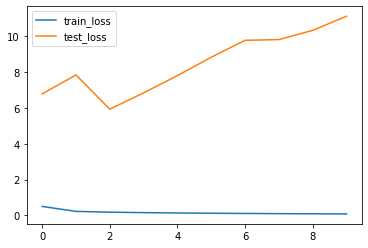

In [13]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'cvae')